# env setting

In [ ]:
#cannot use cs298 env (I don't know why) 
#install all dependencies 
!pip install tensorflow
!pip install pandas
!pip install seaborn

In [152]:
import os
import tensorflow as tf
import glob
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# helper functions
## read data

In [153]:
#helper function from read_result.py
#get Train_EnvstepsSoFar and Eval_AverageReturn

def get_section_results(file):
    """
        requires tensorflow==1.12.0
    """
    X = []
    Y = []
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.tag == 'Train_EnvstepsSoFar':#train steps
                X.append(v.simple_value)
            elif v.tag == 'Eval_AverageReturn':
                Y.append(v.simple_value)
    return X, Y

In [338]:
import os
from collections import defaultdict

#Collect return of multiple different random seeds by experiments name(prefix)

def average_results_of_seeds(prefix):
    
    data = defaultdict(dict) 
    data_diff_seeds = []
    
    
    for filename in os.listdir('data'): # list all files + directories in current folder
        if filename.startswith(prefix): # filter out files that start with specified prefix only
            #print(filename) # found matched files

            # read each file 
            logdir = os.path.join('data', filename, 'events*')
            eventfile = glob.glob(logdir)[0] #retrieve files/pathnames matching a specified pattern
            X, data_this_seed  = get_section_results(eventfile)
   
            data_diff_seeds.append(data_this_seed)#append all the data
            #print(data_this_seed)
    #print(data_diff_seeds)

    #calculate mean and std over seeds
    data['return_mean'] = np.mean(data_diff_seeds, axis=0)
    data['return_std'] = np.std(data_diff_seeds, axis=0)
    #print('data',data)
    data = pd.DataFrame.from_dict(data)#transfrom to pd.DataFrame
    return data


In [328]:
data=average_results_of_seeds(prefix='q1_lb_no_rtg')
data

,return_mean,return_std
0,37.244445,9.311112
1,31.911765,8.088235
2,43.190477,9.476191
3,55.920635,8.365078
4,50.937500,0.562500
...,...,...
95,200.000000,0.000000
96,200.000000,0.000000
97,200.000000,0.000000
98,200.000000,0.000000


In [316]:
#read data from multiple files by name with same prefix
def read_data(exp_name, env_name):
    full_data = pd.DataFrame()

    for filename in os.listdir('data'): # list all files + directories in current folder
        if filename.startswith(exp_name): # filter out files that start with specified prefix(exp_name) only
            print(filename) # found matched files
            
            #read file
            logdir = os.path.join('data', filename, 'events*')#get the whole path of a specific file
            eventfile = glob.glob(logdir)[0] #retrieve files/pathnames matching a specified pattern
            X,Y = get_section_results(eventfile)#read data
            
            
            
            #Automaticly generate plot legend 
            split = filename.split('_')#split folder name of experement data  
            Exp_list = split[1:split.index(env_name)]#
            Exp = '_'.join(Exp_list) 
            
            
            print('split',split)
            print(Exp_list)
            print('Exp',Exp)


            data = pd.DataFrame({'Iteration': range(len(X)), 
                                 'Experiment': np.repeat(Exp, len(X)),
                                 'Train_EnvstepsSoFar': X, 
                                 'Eval_AverageReturn': Y})
            data['Eval_AverageReturn_Smooth'] = data['Eval_AverageReturn'].ewm(alpha=0.6).mean()
            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)
        
    return full_data



In [370]:
#read averaged data of different random seeds for different experiments(short prefix)
#for a whole experiment 
def read_data_average(exp_name, env_name):
    full_data = pd.DataFrame()
    Exps=[]#experiments list for all experiment in a specific task
    
    for filename in os.listdir('data'): # list all files + directories in current folder
        if filename.startswith(exp_name): # filter out files that start with specified prefix(exp_name) only
            #print(filename) # found matched files
            
            #Automaticly generate plot legend 
            split = filename.split('_')#split folder name of experement data  
            Exp_list = split[0:split.index('seed')]
            Exp = '_'.join(Exp_list) 
            '''
            print('split',split)
            print('Exp_list',Exp_list)
            print('Exp',Exp)
            '''
            Exps.append(Exp)
            Exps = list(set(Exps))#remove Duplication name of experiments 
    print(Exps)
    
    #read averaged data of each experiment 
    for Exp in Exps:
        data = average_results_of_seeds(prefix = Exp)
        
        
        
        data = pd.DataFrame({'Iteration': range(len(data['return_mean'])), 
                             'Experiment': np.repeat(Exp[3:], len(data['return_mean'])), 
                             'Eval_AverageReturn_overseeds': data['return_mean'],
                            'Eval_AverageReturn_overseeds_Smooth': data['return_mean'].ewm(alpha=0.6).mean()})
       
        full_data = pd.concat([full_data, data], axis=0, ignore_index=True)
        
    return full_data

data_q1_lb= read_data_average(exp_name='q1_lb',env_name= 'CartPole-v0')
data_q1_lb

['q1_lb_rtg_dsa', 'q1_lb_no_rtg_dsa', 'q1_lb_rtg_na']


,Iteration,Experiment,Eval_AverageReturn_overseeds,Eval_AverageReturn_overseeds_Smooth
0,0,lb_rtg_dsa,31.656410,31.656410
1,1,lb_rtg_dsa,38.531250,36.567010
2,2,lb_rtg_dsa,48.000000,43.895850
3,3,lb_rtg_dsa,60.694443,54.239811
4,4,lb_rtg_dsa,53.571428,53.834632
...,...,...,...,...
295,95,lb_rtg_na,200.000000,199.980065
296,96,lb_rtg_na,196.333336,197.792028
297,97,lb_rtg_na,187.166664,191.416809
298,98,lb_rtg_na,200.000000,196.566724


## Plot functions

In [372]:
#set plot
figsize=(5.7, 3)
export_dir = os.path.join('solution', 'figures')

sns.set_theme()#seaborn  On later versions, it must be explicitly invoked.
sns.set_context("paper")
sns.set_style("whitegrid")

In [367]:
#plot givn data and save figure
def plot(data_to_plot,fig_name):
    plt.figure(figsize=figsize)
    sns.lineplot(data=data_to_plot, x='Iteration', y='Eval_AverageReturn_Smooth', hue='Experiment')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(os.path.join(export_dir, '{}.png'.format(fig_name)), bbox_inches='tight')

In [368]:
#plot givn data and save figure
def plot_overseeds(data_to_plot,fig_name):
    plt.figure(figsize=figsize)
    sns.lineplot(data=data_to_plot, x='Iteration', y='Eval_AverageReturn_overseeds_Smooth', hue='Experiment')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(os.path.join(export_dir, '{}.png'.format(fig_name)), bbox_inches='tight')

In [348]:
#plot givn data and save figure
def plot_mean_std(data_to_plot,fig_name):
    plt.figure(figsize=figsize)
    sns.lineplot(data=data_to_plot, x='Iteration', y='Eval_AverageReturn_Smooth')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(os.path.join(export_dir, '{}.png'.format(fig_name)), bbox_inches='tight')

# Experiment 1

q1_lb_no_rtg_dsa_seed_0_CartPole-v0_02-03-2021_12-11-23
q1_lb_no_rtg_dsa_CartPole-v0_05-02-2021_11-53-46
q1_lb_no_rtg_dsa_seed_1_CartPole-v0_02-03-2021_12-11-23


No handles with labels found to put in legend.


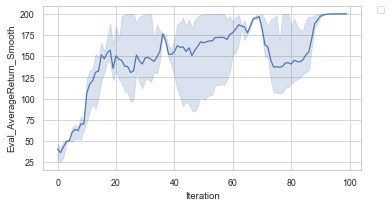

In [257]:
data_q1_lb_no_rtg = read_data('q1_lb_no_rtg','CartPole-v0')
data_q1_lb_no_rtg
plot_mean_std(data_q1_lb_no_rtg, 'data_q1_lb_no_rtg')

q1_lb_rtg_na_seed_0_CartPole-v0_02-03-2021_12-11-23
q1_lb_no_rtg_dsa_seed_0_CartPole-v0_02-03-2021_12-11-23
q1_lb_rtg_dsa_seed_1_CartPole-v0_02-03-2021_12-11-23
q1_lb_rtg_dsa_seed_0_CartPole-v0_02-03-2021_12-11-23
q1_lb_no_rtg_dsa_seed_1_CartPole-v0_02-03-2021_12-11-23
q1_lb_rtg_na_seed_1_CartPole-v0_02-03-2021_12-11-23


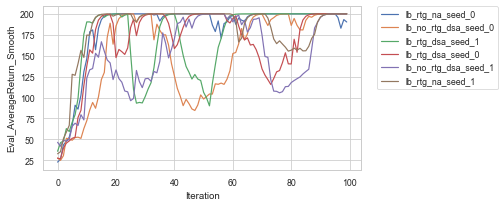

In [296]:
data_q1_lb_no_rtg = read_data('q1_lb','CartPole-v0')
data_q1_lb
plot(data_q1_lb_no_rtg, 'data_q1_lb')

['q1_lb_rtg_dsa', 'q1_lb_no_rtg_dsa', 'q1_lb_rtg_na']


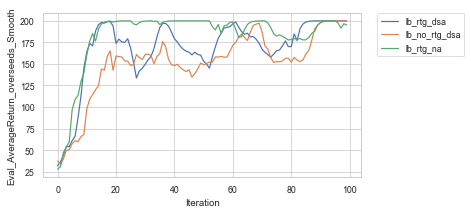

In [371]:
data_q1_lb = read_data_average('q1_lb','CartPole-v0')
data_q1_lb
plot_overseeds(data_q1_lb, 'data_q1_lb')

In [ ]:
data_q1_lb_no_rtg = average_results_seeds(prefix = 'q1_lb_no_rtg')
data_q1_lb_no_rtg
plot_mean_std(data_q1_lb_no_rtg, 'data_q1_lb_no_rtg')

q1_lb_rtg_na_seed_0_CartPole-v0_02-03-2021_12-11-23
q1_lb_rtg_na_CartPole-v0_05-02-2021_12-00-32
q1_lb_rtg_na_seed_1_CartPole-v0_02-03-2021_12-11-23


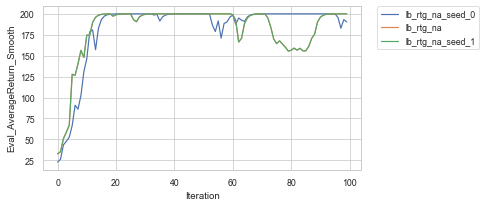

In [216]:
data_q1_lb = read_data('q1','q1_lb_rtg_na','CartPole-v0') #Experiment name
data_q1_lb
plot(data_q1_lb, 'q1_lb')

q1_sb_no_rtg_dsa_seed_1_CartPole-v0_02-03-2021_12-11-23
q1_sb_rtg_na_seed_0_CartPole-v0_02-03-2021_12-11-23
q1_sb_rtg_dsa_seed_1_CartPole-v0_02-03-2021_12-11-23
q1_sb_rtg_dsa_CartPole-v0_05-02-2021_11-51-20
q1_sb_no_rtg_dsa_CartPole-v0_05-02-2021_11-47-58
q1_sb_rtg_dsa_seed_0_CartPole-v0_02-03-2021_12-11-23
q1_sb_no_rtg_dsa_seed_0_CartPole-v0_02-03-2021_12-11-23
q1_sb_rtg_na_seed_1_CartPole-v0_02-03-2021_12-11-23
q1_sb_rtg_na_CartPole-v0_05-02-2021_11-52-46


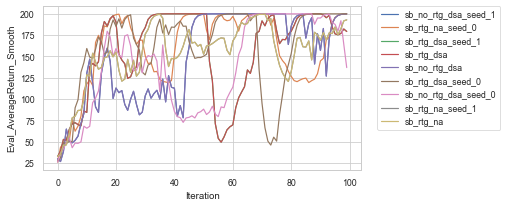

In [218]:
data_q1_sb = read_data('q1','q1_sb','CartPole-v0') #Experiment name
data_q1_sb
plot(data_q1_sb, 'q1_sb')

In [35]:
data_sb = read_q1_data('sb')#small batch size
data_sb

,Iteration,Config,Train_EnvstepsSoFar,Eval_AverageReturn,Eval_AverageReturn_Smooth
0,0,sb_rtg_dsa,1021.0,32.307693,32.307693
1,1,sb_rtg_dsa,2035.0,41.099998,38.587911
2,2,sb_rtg_dsa,3051.0,60.285713,52.496759
3,3,sb_rtg_dsa,4058.0,50.666668,51.369856
4,4,sb_rtg_dsa,5066.0,72.666664,64.280142
...,...,...,...,...,...
295,95,sb_rtg_na,103830.0,189.666672,184.531195
296,96,sb_rtg_na,104898.0,169.333328,175.412475
297,97,sb_rtg_na,105930.0,187.000000,182.364990
298,98,sb_rtg_na,107022.0,198.000000,191.745996


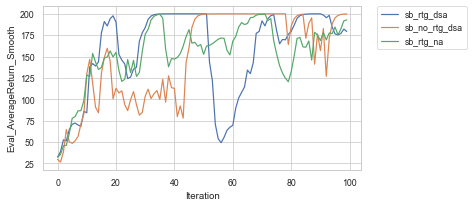

In [37]:
plt.figure(figsize=figsize)
sns.lineplot(data=data_sb, x='Iteration', y='Eval_AverageReturn_Smooth', hue='Config')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(os.path.join(export_dir, 'q1_sb.png'), bbox_inches='tight')


# Experiment 2

In [81]:
def read_q2_data():
    full_data = pd.DataFrame()

    for folder in os.listdir('data'):
        split = folder.split('_')
        if 'q2' in split and 'b500' not in split:
            config_list = split[split.index('q2')+1:split.index('InvertedPendulum-v2')]
            config = '_'.join(config_list)

            logdir = os.path.join('data', folder, 'events*')
            eventfile = glob.glob(logdir)[0]

            X, Y = get_section_results(eventfile)
            data = pd.DataFrame({'Iteration': range(len(X)), 
                                 'Config': np.repeat(config, len(X)), 
                                 'Train_EnvstepsSoFar': X, 
                                 'Eval_AverageReturn': Y})
            data['Eval_AverageReturn_Smooth'] = data['Eval_AverageReturn'].ewm(alpha=0.6).mean()
            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)
        
    return full_data

data_q2 = read_q2_data()
data_q2

,Iteration,Config,Train_EnvstepsSoFar,Eval_AverageReturn,Eval_AverageReturn_Smooth
0,0,b300_r0.02,301.0,7.214286,7.214286
1,1,b300_r0.02,601.0,18.181818,15.048237
2,2,b300_r0.02,909.0,24.705883,21.239036
3,3,b300_r0.02,1221.0,18.272728,19.412492
4,4,b300_r0.02,1564.0,18.608696,18.925225
...,...,...,...,...,...
1795,95,b300_r0.01,50380.0,1000.000000,999.364333
1796,96,b300_r0.01,51380.0,1000.000000,999.745733
1797,97,b300_r0.01,52380.0,1000.000000,999.898293
1798,98,b300_r0.01,53380.0,1000.000000,999.959317


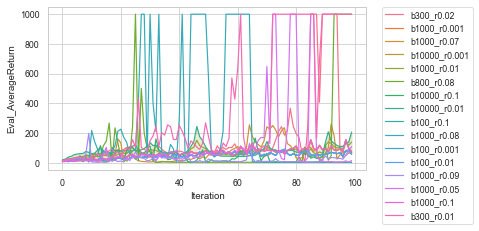

In [82]:
plt.figure(figsize=figsize)
sns.lineplot(data=data_q2, x='Iteration', y='Eval_AverageReturn', hue='Config')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(os.path.join(export_dir, 'q2.png'), bbox_inches='tight')

In [83]:
def read_q2_optimal():
    full_data = pd.DataFrame()

    for folder in os.listdir('data'):
        split = folder.split('_')
        if 'q2' in split and 'b300' in split and 'r0.01' in split:
            config_list = split[split.index('q2')+1:split.index('InvertedPendulum-v2')]
            config = '_'.join(config_list)

            logdir = os.path.join('data', folder, 'events*')
            eventfile = glob.glob(logdir)[0]

            X, Y = get_section_results(eventfile)
            data = pd.DataFrame({'Iteration': range(len(X)), 
                                 'Config': np.repeat(config, len(X)), 
                                 'Train_EnvstepsSoFar': X, 
                                 'Eval_AverageReturn': Y})
            data['Eval_AverageReturn_Smooth'] = data['Eval_AverageReturn'].ewm(alpha=0.6).mean()
            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)
        
    return full_data

data_q2_optimal = read_q2_optimal()
data_q2_optimal

,Iteration,Config,Train_EnvstepsSoFar,Eval_AverageReturn,Eval_AverageReturn_Smooth
0,0,b300_r0.01,301.0,9.902439,9.902439
1,1,b300_r0.01,616.0,20.100000,17.186411
2,2,b300_r0.01,931.0,22.473684,20.575689
3,3,b300_r0.01,1238.0,22.736841,21.906448
4,4,b300_r0.01,1545.0,30.857143,27.332427
...,...,...,...,...,...
95,95,b300_r0.01,50380.0,1000.000000,999.364333
96,96,b300_r0.01,51380.0,1000.000000,999.745733
97,97,b300_r0.01,52380.0,1000.000000,999.898293
98,98,b300_r0.01,53380.0,1000.000000,999.959317


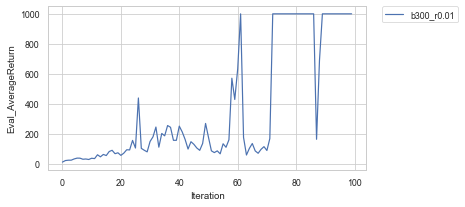

In [80]:
plt.figure(figsize=figsize)
sns.lineplot(data=data_q2_optimal, x='Iteration', y='Eval_AverageReturn', hue='Config')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(os.path.join(export_dir, 'q2_optimal.png'), bbox_inches='tight')

# Experiment 3

In [57]:
def read_q3_data():
    full_data = pd.DataFrame()

    for folder in os.listdir('data'):
        split = folder.split('_')
        if 'LunarLanderContinuous-v2' in split:
            print(split)
            config_list = split[split.index('q3')+1:split.index('LunarLanderContinuous-v2')]
            config = '_'.join(config_list)
            print(config_list)

            logdir = os.path.join('data', folder, 'events*')
            eventfile = glob.glob(logdir)[0]

            X, Y = get_section_results(eventfile)
            data = pd.DataFrame({'Iteration': range(len(X)), 
                                 'Config': np.repeat(config, len(X)), 
                                 'Train_EnvstepsSoFar': X, 
                                 'Eval_AverageReturn': Y})
            data['Eval_AverageReturn_Smooth'] = data['Eval_AverageReturn'].ewm(alpha=0.6).mean()
            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)
        
    return full_data

data_q3 = read_q3_data()
data_q3

['q3', 'b40000', 'r0.005', 'LunarLanderContinuous-v2', '25-02-2021', '09-01-56']
['b40000', 'r0.005']


,Iteration,Config,Train_EnvstepsSoFar,Eval_AverageReturn,Eval_AverageReturn_Smooth
0,0,b40000_r0.005,40006.0,-170.867661,-170.867661
1,1,b40000_r0.005,80028.0,-166.667694,-167.867685
2,2,b40000_r0.005,120126.0,-137.896515,-148.655396
3,3,b40000_r0.005,160133.0,-106.609131,-122.764839
4,4,b40000_r0.005,200189.0,-107.254654,-113.362447
...,...,...,...,...,...
95,95,b40000_r0.005,3876389.0,191.620071,180.216402
96,96,b40000_r0.005,3916869.0,144.128159,158.563456
97,97,b40000_r0.005,3957162.0,194.534454,180.146055
98,98,b40000_r0.005,3997520.0,185.727219,183.494753


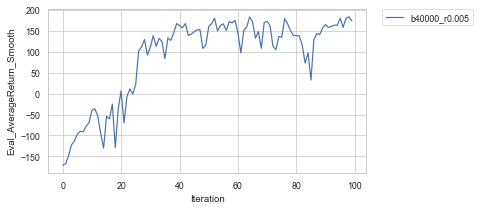

In [58]:
plt.figure(figsize=figsize)
sns.lineplot(data=data_q3, x='Iteration', y='Eval_AverageReturn_Smooth', hue='Config')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(export_dir, 'q3.png'), bbox_inches='tight')

# Experiment 4

In [70]:
def read_q4_data():
    full_data = pd.DataFrame()

    for folder in os.listdir('data'):
        split = folder.split('_')
        if 'HalfCheetah-v2' in split and 'search' in split:
            config_list = split[split.index('search')+1:split.index('rtg')]
            config = '_'.join(config_list)
            print('config_list',config_list)

            logdir = os.path.join('data', folder, 'events*')
            eventfile = glob.glob(logdir)[0]

            X, Y = get_section_results(eventfile)
            data = pd.DataFrame({'Iteration': range(len(X)), 
                                 'Config': np.repeat(config, len(X)), 
                                 'Train_EnvstepsSoFar': X, 
                                 'Eval_AverageReturn': Y})
            data['Eval_AverageReturn_Smooth'] = data['Eval_AverageReturn'].ewm(alpha=0.6).mean()

            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)
        
    return full_data

data_q4 = read_q4_data()
data_q4

config_list ['b10000', 'lr0.02']
config_list ['b50000', 'lr0.02']
config_list ['b10000', 'lr0.005']
config_list ['b30000', 'lr0.01']
config_list ['b10000', 'lr0.01']
config_list ['b50000', 'lr0.01']
config_list ['b30000', 'lr0.02']
config_list ['b30000', 'lr0.005']
config_list ['b50000', 'lr0.005']


,Iteration,Config,Train_EnvstepsSoFar,Eval_AverageReturn,Eval_AverageReturn_Smooth
0,0,b10000_lr0.02,10050.0,-100.361000,-100.361000
1,1,b10000_lr0.02,20100.0,-100.429909,-100.410221
2,2,b10000_lr0.02,30150.0,-88.949677,-93.063718
3,3,b10000_lr0.02,40200.0,-90.673943,-91.592181
4,4,b10000_lr0.02,50250.0,-66.532295,-76.400689
...,...,...,...,...,...
895,95,b50000_lr0.005,4809600.0,56.642487,52.617941
896,96,b50000_lr0.005,4859700.0,23.415741,35.096621
897,97,b50000_lr0.005,4909800.0,58.590698,49.193067
898,98,b50000_lr0.005,4959900.0,37.451160,42.147923


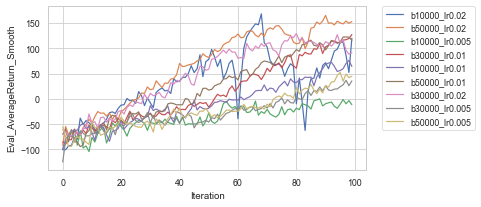

In [64]:
plt.figure(figsize=figsize)
sns.lineplot(data=data_q4, x='Iteration', y='Eval_AverageReturn_Smooth', hue='Config')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(os.path.join(export_dir, 'q4_search.png'), bbox_inches='tight')

In [71]:
def read_q4_optimal_data():
    full_data = pd.DataFrame()

    for folder in os.listdir('data'):
        split = folder.split('_')
        if 'HalfCheetah-v2' in split and 'search' not in split:
            config_list = split[split.index('q4')+1:split.index('HalfCheetah-v2')]

            config = '_'.join(config_list)
            print('config_list',config_list)

            logdir = os.path.join('data', folder, 'events*')
            eventfile = glob.glob(logdir)[0]

            X, Y = get_section_results(eventfile)
            data = pd.DataFrame({'Iteration': range(len(X)), 
                                 'Config': np.repeat(config, len(X)), 
                                 'Train_EnvstepsSoFar': X, 
                                 'Eval_AverageReturn': Y})
            data['Eval_AverageReturn_Smooth'] = data['Eval_AverageReturn'].ewm(alpha=0.6).mean()

            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)
        
    return full_data

data_q4_optimal = read_q4_optimal_data()
data_q4_optimal

config_list ['b50000', 'r0.02', 'nnbaseline']
config_list ['b50000', 'r0.02', 'rtg', 'nnbaseline']
config_list ['b50000', 'r0.02', 'rtg']
config_list ['b50000', 'r0.02', 'rtg', 'nnbaseline']
config_list ['b50000', 'r0.02']
config_list ['b50000', 'r0.02', 'nnbaseline']
config_list ['b50000', 'r0.02']
config_list ['b50000', 'r0.02', 'rtg']


,Iteration,Config,Train_EnvstepsSoFar,Eval_AverageReturn,Eval_AverageReturn_Smooth
0,0,b50000_r0.02_nnbaseline,50100.0,-56.248901,-56.248901
1,1,b50000_r0.02_nnbaseline,100200.0,-95.670837,-84.407427
2,2,b50000_r0.02_nnbaseline,150300.0,-81.331490,-82.435672
3,3,b50000_r0.02_nnbaseline,200400.0,-105.839119,-96.846662
4,4,b50000_r0.02_nnbaseline,250500.0,-113.157631,-106.734495
...,...,...,...,...,...
722,95,b50000_r0.02_rtg,4809600.0,133.460159,131.967812
723,96,b50000_r0.02_rtg,4859700.0,128.441238,129.851868
724,97,b50000_r0.02_rtg,4909800.0,140.650543,136.331073
725,98,b50000_r0.02_rtg,4959900.0,140.301254,138.713182


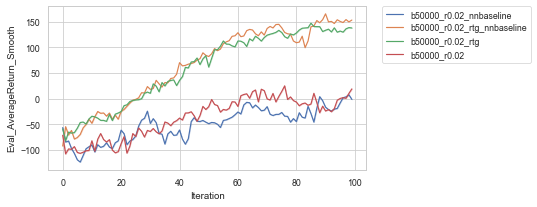

In [72]:
plt.figure(figsize=figsize)
sns.lineplot(data=data_q4_optimal, x='Iteration', y='Eval_AverageReturn_Smooth', hue='Config')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(os.path.join(export_dir, 'q4_optimal.png'), bbox_inches='tight')